(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import AutoEncode library
import AutoEncode

# Import package to save outputs
import BSON

# Import basic math
import LinearAlgebra
import StatsBase

# Import clustering algorithms
import Clustering

# Import ML libraries
import Flux
import Zygote

# Import library to set random seed
import Random

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.theme_makie!()

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt /Users/mrazo/.julia/packages/Flux/u7QSl/ext/FluxCUDAExt/FluxCUDAExt.jl:56


## Simple 3D example

To begin our exploration of the differential geometry ideas, let's work with a
simple example. Let us define a function of the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \alpha \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

Let's load the dataset used to train some of the models. These data have been
standardized to have a mean of zero and a variance of one on each dimension.

In [2]:
# Define number of epohcs
n_epoch = 50_000
# Define how often error should be computd
n_error = 1_000

# Define filename
fname = "$(git_root())/code/processing/" *
        "combvae_jointencoder_simpledecoder_3Dpeak/output/$(n_epoch)_epoch/" *
        "combvae_2dimensions.bson"
# Load data
data_std = BSON.load(fname)[:data_std]

3×10000 Matrix{Float32}:
 -0.750783  -0.104714   0.797325  …   0.222734  -1.10543   0.362391
  0.399705  -1.12509    0.611173      1.49329    0.500001  0.526342
  0.462347  -0.273895  -0.072353     -0.507905  -0.348303  1.34058

Let's look at both the input and the output space. The color on each point
represents their value of the third dimension in the output space.

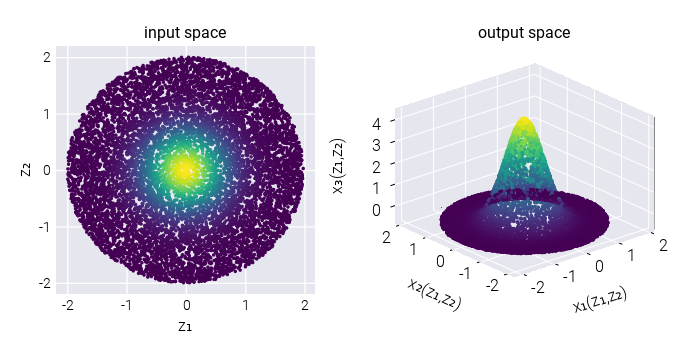

In [3]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for input space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="input space"
)

# Plot input space
scatter!(
    ax_input,
    data_std[1, :],
    data_std[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="x₁(z₁,z₂)",
    ylabel="x₂(z₁,z₂)",
    zlabel="x₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E6E6EF",
    xzpanelcolor="#E6E6EF",
    yzpanelcolor="#E6E6EF",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_output,
    eachrow(data_std)...,
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Separate axis
colgap!(gl, 50)

fig

With this data in hand, let's look at some of the variational autoencoders.

## `VAE{JointDecoder,SimpleDecoder}`

Let's begin by looking at the simplest variational autoencoder. This autoencoder
is composed of two elements:
1. An encoder that maps from the data space $\underline{x} \in \mathbb{R}^3$ to
   the mean and log standard deviation of the distribution in latent space,
   $\underline{\mu}_z(\underline{x}), \ln\underline{\sigma}_z(\underline{x}) \in
   \mathbb{R}^2$. In other words, it gives the parametrization of
   $\pi(\underline{z}\mid\underline{x})$.
2. A decoder that maps from a sample in latent space $\underline{z} \sim
   \mathcal{N}(\underline{\mu}_z(\underline{x}),
   \ln\underline{\sigma}_z(\underline{x}))$ to **a single estimate (the MAP)**
   in data space $\underline{\hat{x}} \in \mathbb{R}^3$.

I highlight that it is a single estimate since this vanilla VAE assumes a 
constant variance for the output, thus the decoder does not return a value for 
the estimated variance. This means that this VAE structure asssumes
$$
\pi(\underline{x}\mid\underline{z}) =
\mathcal{N}(
    \underline{\mu}_x(\underline{z}), \underline{\underline{I}} \sigma^2
),
$$
therefore, the decoder only returns the mean of the posterior distribution.

Let's load the results into memory.

In [4]:
# Define number of epohcs
n_epoch = 50_000
# Define how often error should be computd
n_error = 1_000

# Define filename
fname = "$(git_root())/code/processing/" *
        "combvae_jointencoder_simpledecoder_3Dpeak/output/$(n_epoch)_epoch/" *
        "combvae_2dimensions.bson"
# Load model
vae = BSON.load(fname)[:vae]
# Load mean squared error
mse = BSON.load(fname)[:mse]
# Load loss function
loss = BSON.load(fname)[:loss]
# Load KL divergence
kl = BSON.load(fname)[:kl]
# Load data
data = BSON.load(fname)[:data]
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Let's look at the mean squared error over epoch number as the training
progresses.

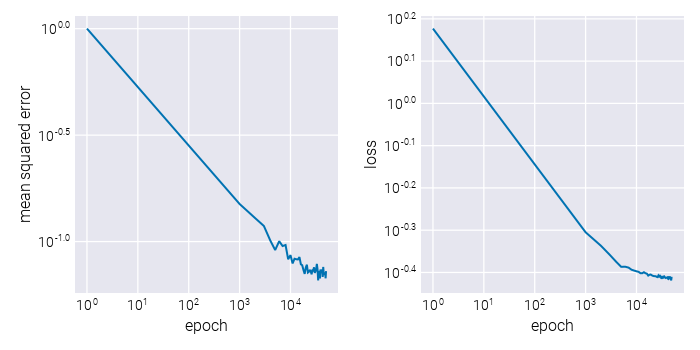

In [5]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    yscale=log10,
    xscale=log10,
)

# Plot error
lines!(ax, [collect(1:n_error:n_epoch); [n_epoch]], mse)

# Add axis
ax2 = Axis(
    fig[1, 2],
    xlabel="epoch",
    ylabel="loss",
    yscale=log10,
    xscale=log10,
)

# Plot error
lines!(ax2, [collect(1:n_error:n_epoch); [n_epoch]], loss)


fig

We can see that the mean-squared error is indeed decreasing as the training
progresses.

Let's look at the resemblance between the input and the output of this
autoencoder. For this, we will plot the true value of the function and the
autoencoder-reconstructed value side-to-side. To make sure that the
reconstruction keeps the structure of the data, we will color the points by
their true $x_3$-value dictated by our function as well as by the angle on the
$x-y$-plane to make sure the autoencoder learned to distinguish the points
despite the circular symmetry.

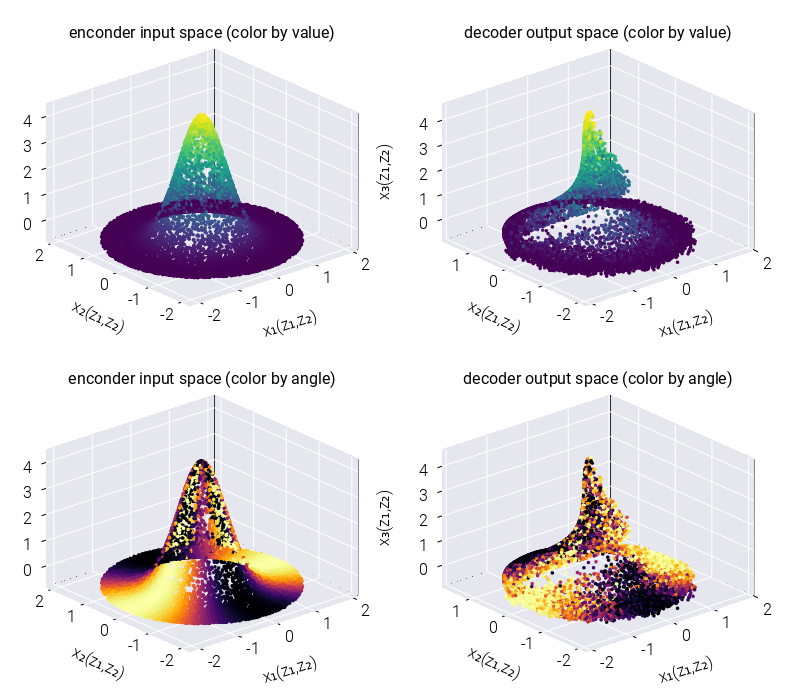

In [6]:
Random.seed!(42)

# Initialize figure
fig = Figure(resolution=(2 * 400, 2 * 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

ax = [
    Axis3(
        gl[i, j],
        xlabel="x₁(z₁,z₂)",
        ylabel="x₂(z₁,z₂)",
        zlabel="x₃(z₁,z₂)",
        xypanelcolor="#E6E6EF",
        xzpanelcolor="#E6E6EF",
        yzpanelcolor="#E6E6EF",
        xgridcolor=:white,
        ygridcolor=:white,
        zgridcolor=:white,
    ) for i = 1:2 for j = 1:2
]

# Reshape axis
ax = permutedims(reshape(ax, 2, 2), (2, 1))

# Plot output space (color by z-value)
scatter!(
    ax[1, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 1].title = "enconder input space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=atan.(data_std[1, :] .^ 2, data_std[2, :] .^ 2),
    colormap=:inferno,
)

# Add title
ax[2, 1].title = "enconder input space (color by angle)"

# Pass data through autoencoder
data_vae = vae(data_std)

# Plot output space (color by z-value)
scatter!(
    ax[1, 2],
    data_vae[1, :],
    data_vae[2, :],
    data_vae[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 2].title = "decoder output space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 2],
    data_vae[1, :],
    data_vae[2, :],
    data_vae[3, :],
    markersize=5,
    color=atan.(data_std[1, :] .^ 2, data_std[2, :] .^ 2),
    colormap=:inferno,
)

# Add title
ax[2, 2].title = "decoder output space (color by angle)"

fig

Although not perfect, The reconstruction seems to work decently well.

Next, let's map the input data (3D points) into the latent space (2D points) via
the encoder. Again, we will plot the value, assigning color based on the input
$z$-value determined by our function.

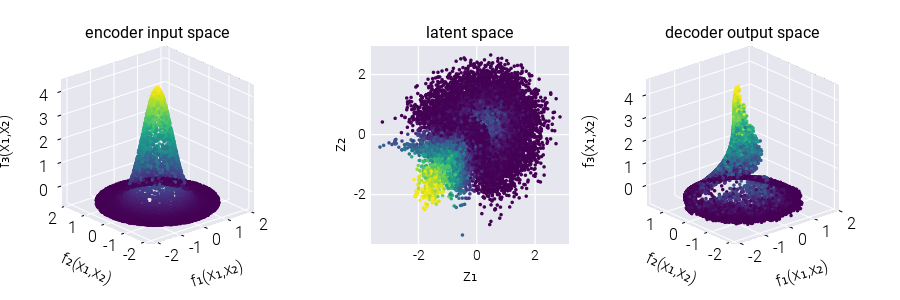

In [7]:
# Map input data to latent space
data_latent = vae(data_std, latent=true)[3]

# Initialize figure
fig = Figure(resolution=(3 * 300, 300))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for output space
ax_input = Axis3(
    gl[1, 1],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="encoder input space",
    xypanelcolor="#E6E6EF",
    xzpanelcolor="#E6E6EF",
    yzpanelcolor="#E6E6EF",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
    aspect=(1, 1, 1)
)

# Plot output space
scatter!(
    ax_input,
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add axis for latent space
ax_latent = Axis(
    gl[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space",
    aspect=AxisAspect(1)
)

# Plot latent space
scatter!(
    ax_latent,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Add axis for output space
ax_output = Axis3(
    gl[1, 3],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="decoder output space",
    xypanelcolor="#E6E6EF",
    xzpanelcolor="#E6E6EF",
    yzpanelcolor="#E6E6EF",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
    aspect=(1, 1, 1)
)


# Plot output space (color by z-value)
scatter!(
    ax_output,
    data_vae[1, :],
    data_vae[2, :],
    data_vae[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Separate axis
colgap!(gl, 20)

fig

We can see that the learned latent space does not exactly match the "real"
latent space.

### Computing the Riemmanian measure

`[explanation here]`

Let's define a grid of points on the $z_1-z_2$-plane on the latent space and
evaluate the measure, i.e., the square root of the determinant of the metric
tensor.

In [8]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-3.5, 3.5, n_range)

# Initialize matrix to save metric
latent_measure = Matrix{Float32}(undef, n_range, n_range)

# Loop through first latent variable
for (i, x) in enumerate(z1)
    # Loop through second latent variable
    for (j, y) in enumerate(z2)
        # Compute the Riemmanian measure via the determinant of the metric
        # tensor
        latent_measure[i, j] = sqrt(
            LinearAlgebra.det(
                AutoEncode.diffgeo.riemannian_metric(
                    vae.decoder, [x, y]
                )
            )
        )
    end # for
end # for

Now, let's plot the this metric with and without the input data.

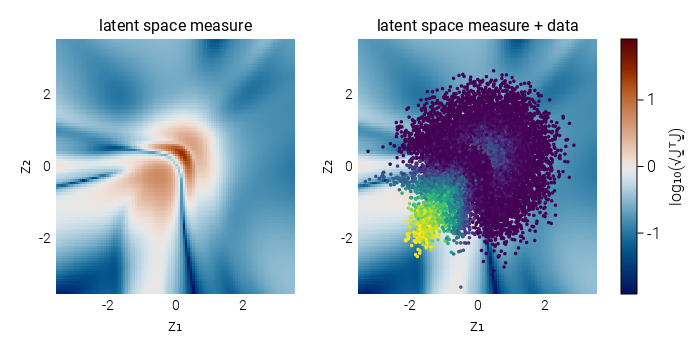

In [9]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add axis for latent space
ax1 = Axis(
    fig[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space measure"
)

# Define range of values
colorrange = (
    -maximum(
        abs.([minimum(log10.(latent_measure)), maximum(log10.(latent_measure))])
    ),
    maximum(
        abs.([minimum(log10.(latent_measure)), maximum(log10.(latent_measure))])
    )
)
# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, log10.(latent_measure), colormap=:vik, colorrange=colorrange
)


# Add axis for latent space
ax2 = Axis(
    fig[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space measure + data"
)

# Plot metric as a heatmap
heatmap!(
    ax2, z1, z2, log10.(latent_measure), colormap=:vik, colorrange=colorrange
)

# Plot latent space
scatter!(
    ax2,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="log₁₀(√J̲̲ᵀJ̲̲)")

fig